###Notebook checking the connectivity of the enhanced connectomes.  

This is just a visulization of the results as a sanity check. 

* The connectomes were generated using ../computation/run_plasticity_rewiring.py and it's corresponding config .json
* Simplex counts and edge participation were computed using ../compuation/simplex_counts_enhanced.py

In [1]:
import conntility
import pandas as pd
import numpy as np 
import scipy.sparse as sp
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# Load data 
root="/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/manipulation_selection/data/"
ns=[4, 20, 66, 100, 200, 300, 400, 500, 270, 470, 670]
names=[f'V5_enhanced_{n}k' for n in ns] 
sc, max_edge_par={},{}
for name in ["baseline"]+names:
    key=name[12:] if name!='baseline' else name 
    sc[key]=pd.read_pickle(f'{root}sc_EE_{name}.pkl')
    max_edge_par[key]=(pd.read_pickle(f'{root}edge_par_EE_{name}.pkl')>0).sum(axis=0).drop(0)

sc=pd.DataFrame.from_dict(sc)
max_edge_par=pd.DataFrame.from_dict(max_edge_par)


### Plotting all enhanced connectomes 

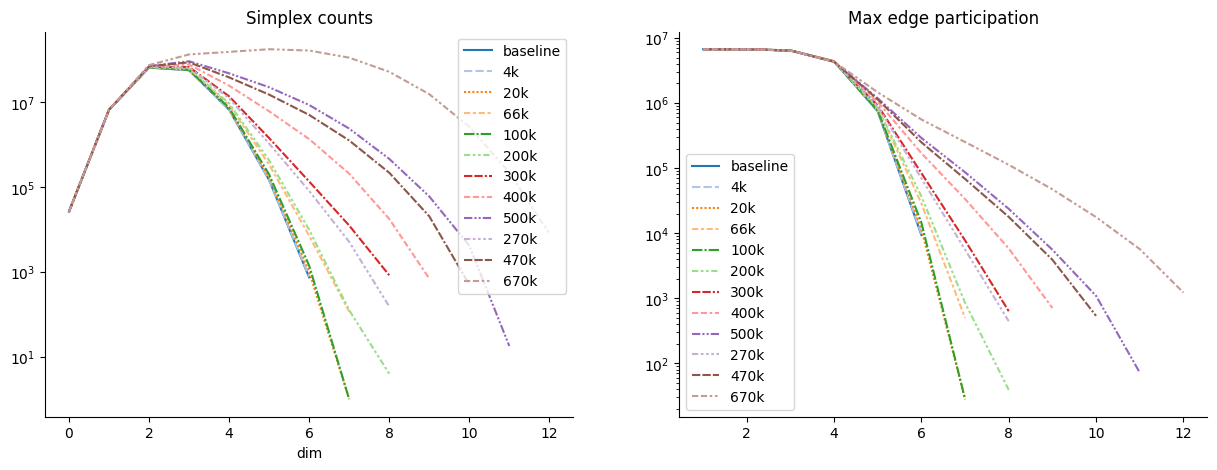

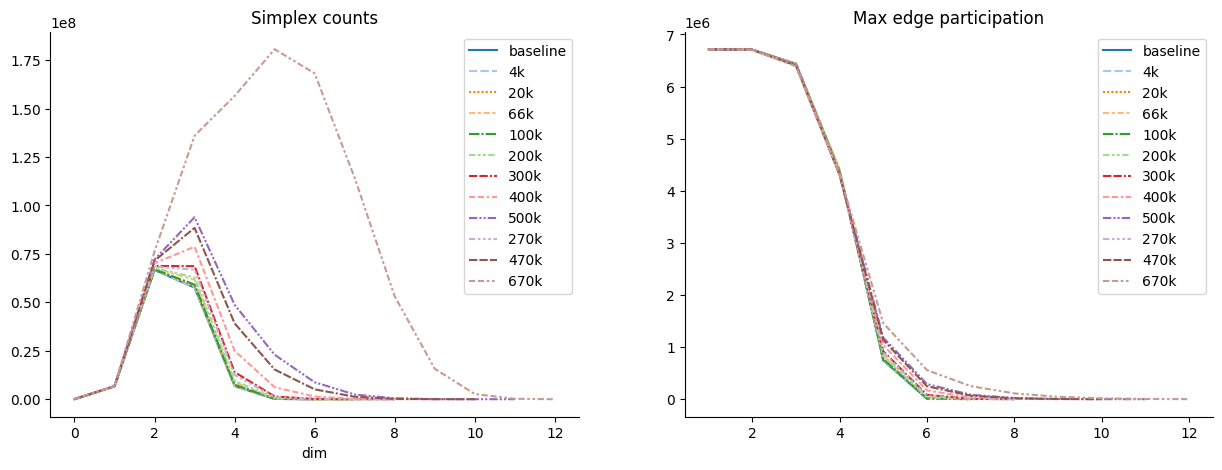

In [3]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(sc, ax=axs[0], palette="tab20")
axs[0].set_title("Simplex counts") 
sns.lineplot(max_edge_par, ax=axs[1], palette="tab20")
axs[1].set_title("Max edge participation") 
for ax in axs.flatten():
    ax.spines[["top", "right"]].set_visible(False) 
    ax.set_yscale("log")

fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(sc, ax=axs[0], palette="tab20")
axs[0].set_title("Simplex counts") 
sns.lineplot(max_edge_par, ax=axs[1], palette="tab20")
axs[1].set_title("Max edge participation") 
for ax in axs.flatten():
    ax.spines[["top", "right"]].set_visible(False) 


### Plotting selection for simulation 

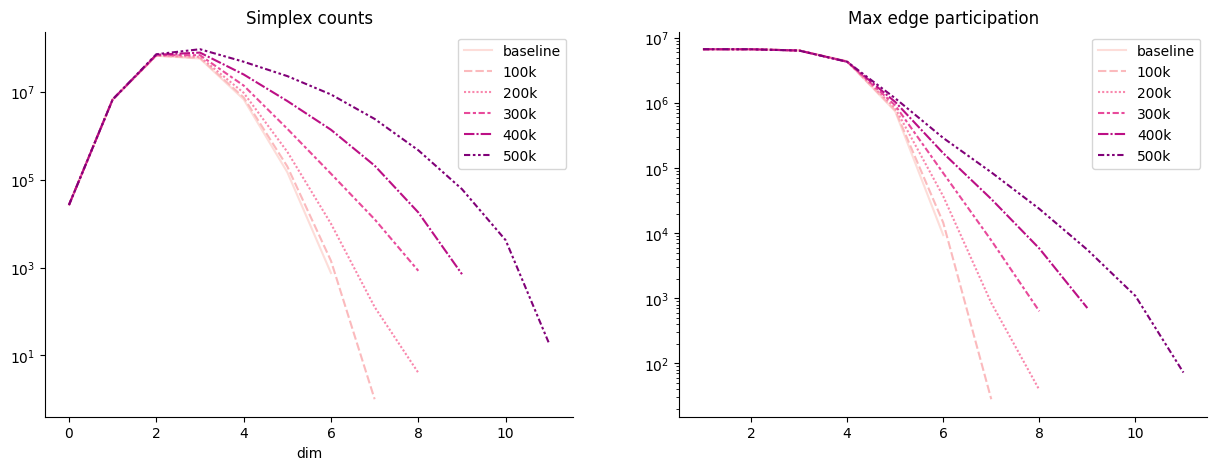

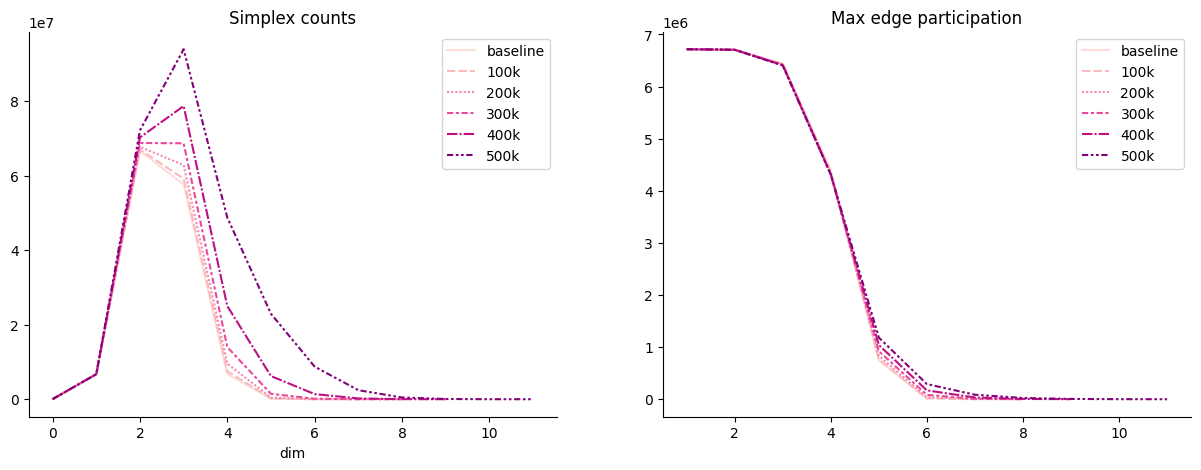

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
select=['baseline']+[f'{n}00k' for n in np.arange(5)+1]
sns.lineplot(sc.loc[:, select], ax=axs[0], palette="RdPu")
axs[0].set_title("Simplex counts") 
sns.lineplot(max_edge_par.loc[:, select], ax=axs[1], palette="RdPu")
axs[1].set_title("Max edge participation") 
for ax in axs.flatten():
    ax.spines[["top", "right"]].set_visible(False) 
    ax.set_yscale("log")

fig, axs = plt.subplots(1,2,figsize=(15,5))
select=['baseline']+[f'{n}00k' for n in np.arange(5)+1]
sns.lineplot(sc.loc[:, select], ax=axs[0], palette="RdPu")
axs[0].set_title("Simplex counts") 
sns.lineplot(max_edge_par.loc[:, select], ax=axs[1], palette="RdPu")
axs[1].set_title("Max edge participation") 
for ax in axs.flatten():
    ax.spines[["top", "right"]].set_visible(False) 

# Connectomes

In [5]:
# Basic check on edge differences

In [6]:
connectomes={}
connectomes['baseline']=conntility.ConnectivityMatrix.from_h5(
    "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline/working_dir/connectome.h5")#.matrix.astype(bool)
ns=[4, 20, 66, 100, 200, 300, 400, 500, 270, 470, 670]
for n in ns:
    path=f"/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/manipulation_selection/data/V5_enhanced_{n}k.h5"
    connectomes[f"{n}k"]=conntility.ConnectivityMatrix.from_h5(path)#.matrix.astype('bool')

In [7]:
# Checking number of edges changed 
diff={}
for n in ns: 
    diff[f"{n}k"]=(connectomes['baseline'].matrix.astype('bool').tocsr()-connectomes[f"{n}k"].matrix.astype('bool').tocsr()).sum()
diff=pd.DataFrame.from_dict(diff, orient="index", columns=["changed"])
diff['target']=np.array(ns)*2000 # Number of target edges to be different (twice the number of those added/removed)
diff['per']=diff['changed']*100/diff['target']
diff

# Checking number of edges total 
edge_counts={'full':{}, 'EE':{}}
for key in connectomes.keys(): 
    edge_counts['full'][key]= connectomes[key].matrix.astype(bool).tocsr().sum()    
    edge_counts['EE'][key]= connectomes[key].index('synapse_class').isin("EXC").matrix.tocsr().astype(bool).sum()
edge_counts=pd.DataFrame.from_dict(edge_counts)
edge_counts["full_per"]=edge_counts["full"]*100/edge_counts["full"]["baseline"]
edge_counts["full_per"]=edge_counts["full"]*100/edge_counts["full"]["baseline"]
edge_counts["EE_per"]=edge_counts["EE"]*100/edge_counts["EE"]["baseline"]
edge_counts

,full,EE,full_per,EE_per
baseline,7803528,6717001,100.0,100.0
4k,7803528,6717001,100.0,100.0
20k,7803528,6717001,100.0,100.0
66k,7803528,6717001,100.0,100.0
100k,7803528,6717001,100.0,100.0
200k,7803528,6717001,100.0,100.0
300k,7803528,6717001,100.0,100.0
400k,7803528,6717001,100.0,100.0
500k,7803528,6717001,100.0,100.0
270k,7803528,6717001,100.0,100.0


In [8]:
# Saving connectomes of selected enhancements for the connectome manipulator 
for n in np.append(np.arange(100, 600, 100), 670):
    path_out=f"/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/manipulation_selection/data/V5_enhanced_mat_{n}k.npz"
    sp.save_npz(path_out, connectomes[f"{n}k"].matrix.astype(bool).tocsr())